# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset represents results from 17 different direct marketing campaigns conducted by a Portuguese banking institution between 2008 and 2013.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [10]:
# Problem 3: Check data types and potential 'unknown' values

# Show data types
print("Data types:\n", df.dtypes)

# Check for nulls
print("\nMissing values:\n", df.isnull().sum())

# Check for 'unknown' values in each column (categorical missingness)
unknown_counts = df.apply(lambda col: (col == 'unknown').sum() if col.dtypes == 'object' else 0)
print("\n'Unknown' entries per column:\n", unknown_counts[unknown_counts > 0])

# Comment on duration
print("\nNote: The 'duration' column should not be used as a predictive feature.")

Data types:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Missing values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y        

After reviewing the dataset and the feature descriptions, I found that none of the columns contain actual missing values (NaN). However, several categorical variables (such as job, education, default, housing, and loan) include the value 'unknown', which should be treated as missing or imputed during preprocessing.

Additionally, the duration column should be excluded from modeling. It captures the length of the last call, which directly influences the outcome (y) and is only known after the interaction. Including it would result in data leakage and an unrealistic predictive model.

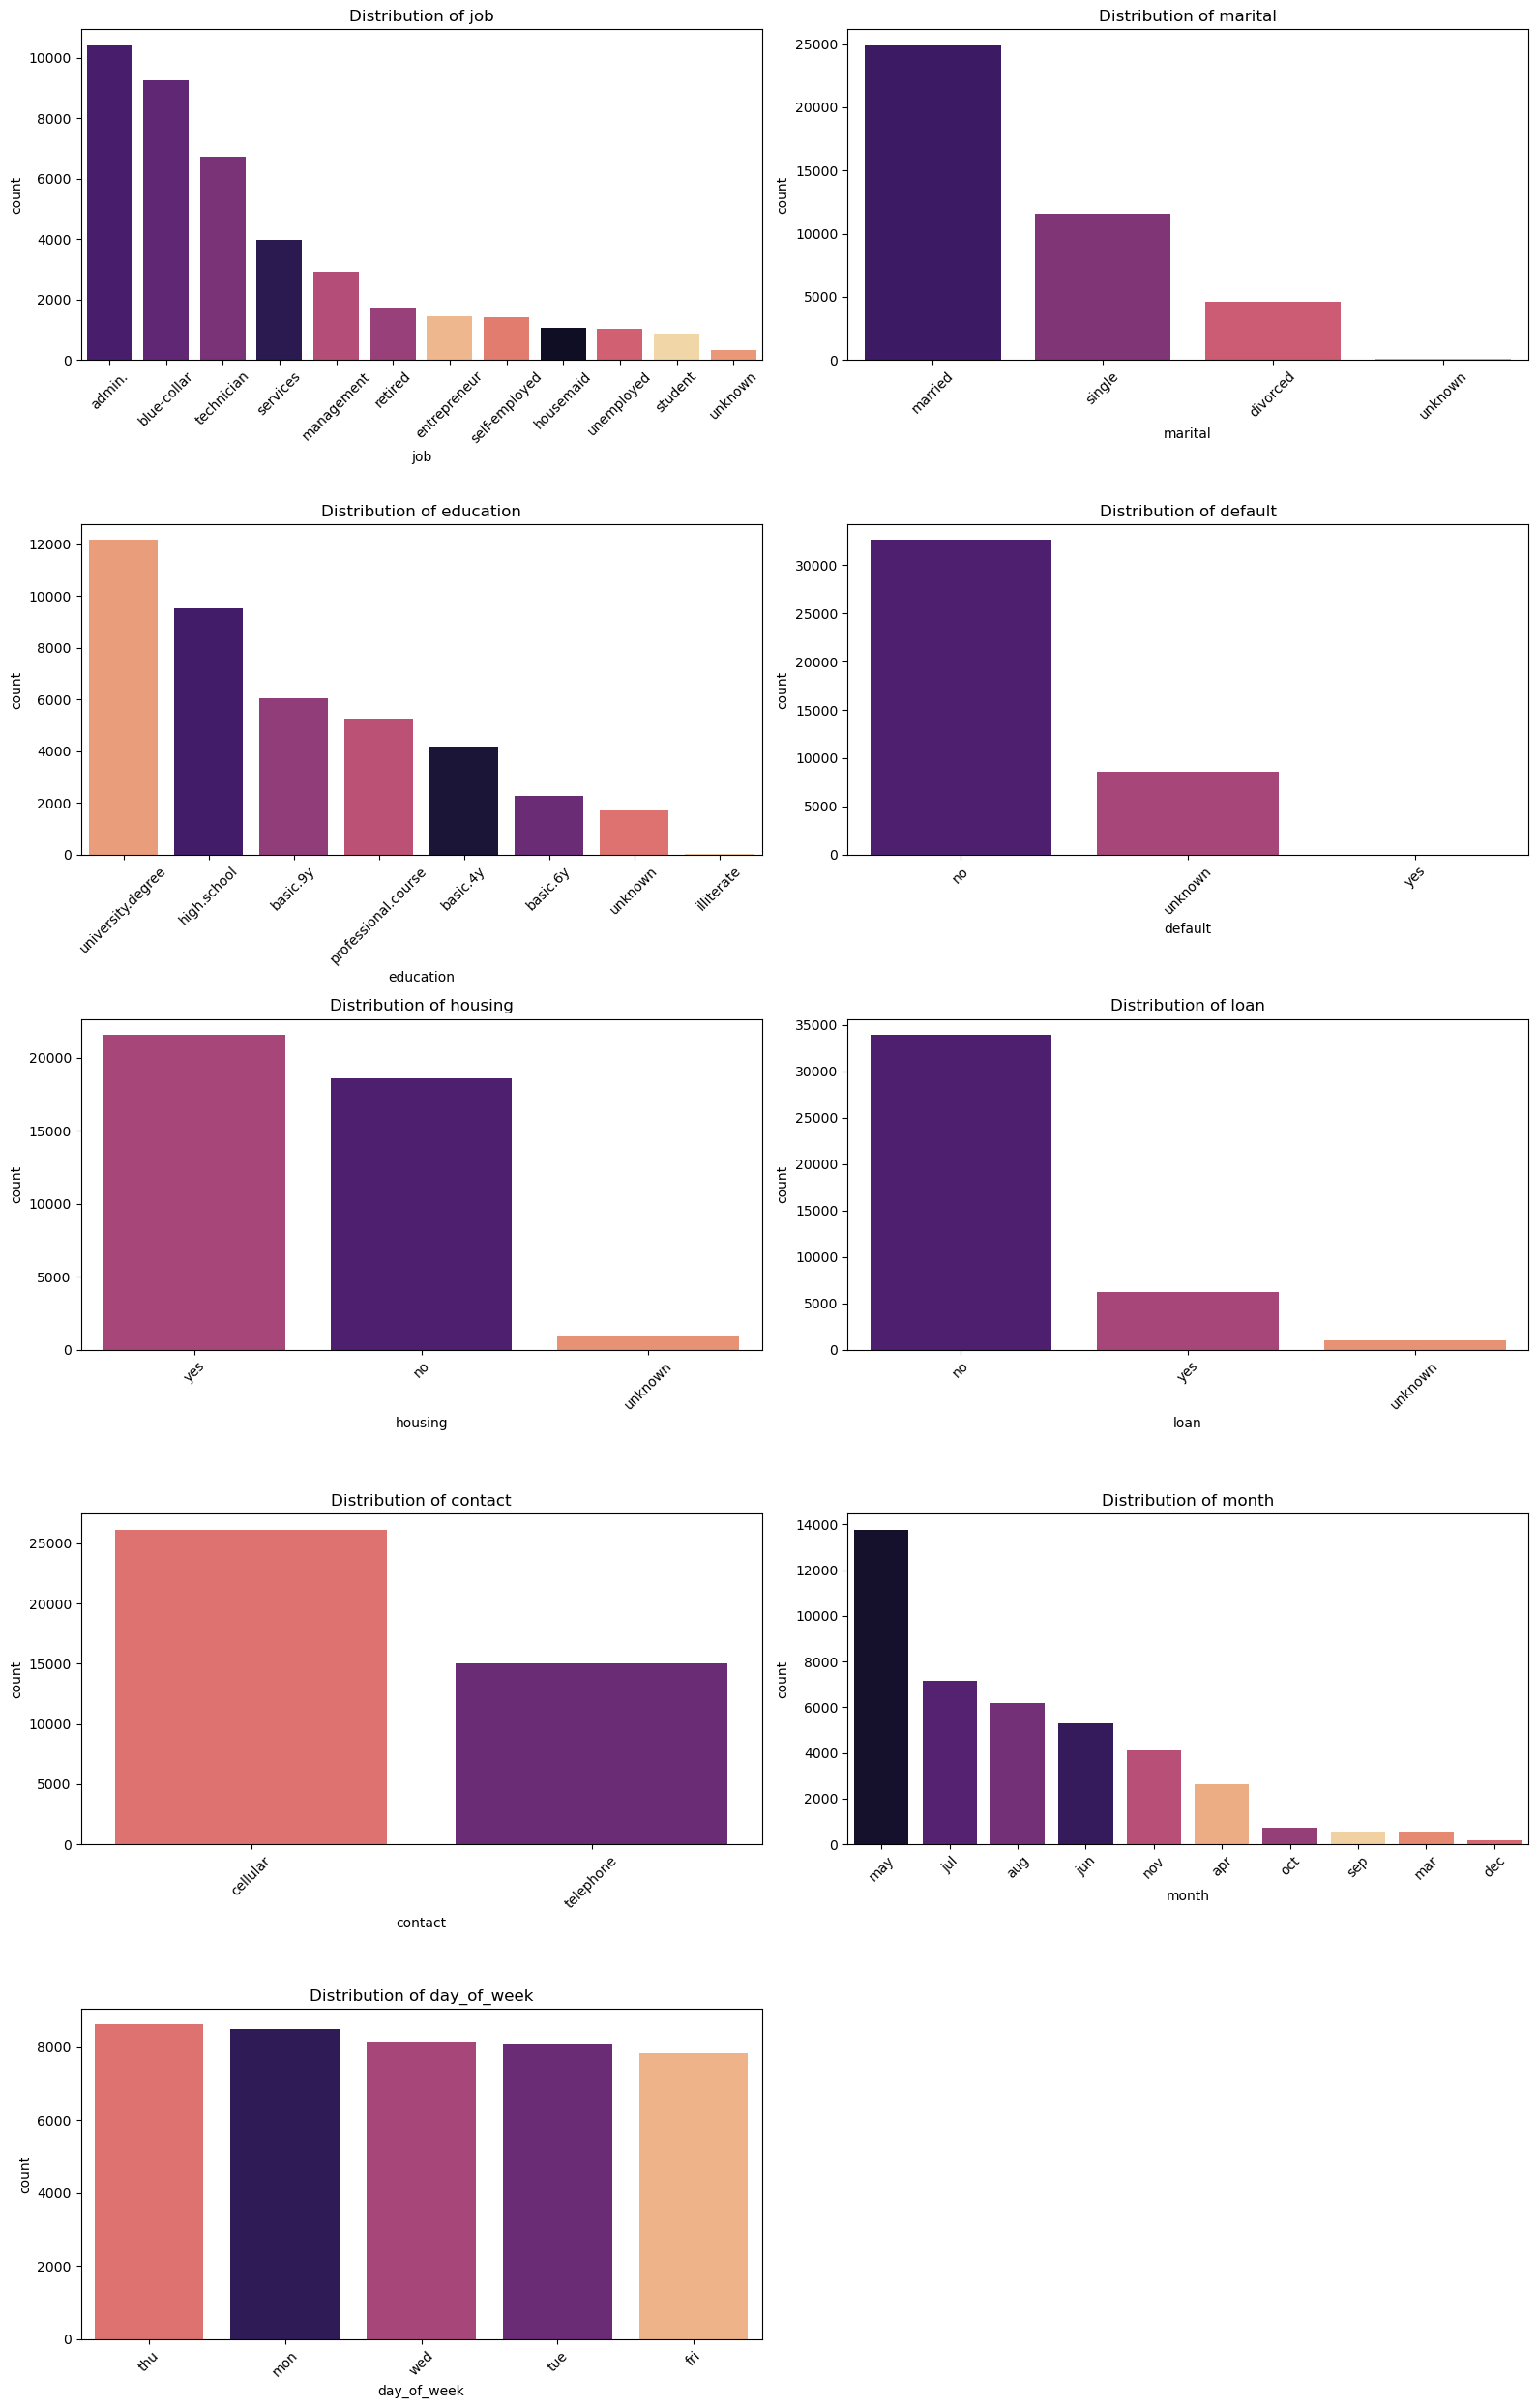

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define features for bank-related info
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
target = 'y'

# Subset data
df_bank = df[bank_features + [target]].copy()

# Encode target
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})

# One-hot encode categoricals
df_encoded = pd.get_dummies(df_bank, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week'], drop_first=True)


# Plot distribution of categorical variables
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']

plt.figure(figsize=(16, 25))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df_bank, x=col, order=df_bank[col].value_counts().index, hue = col, palette='magma')
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()


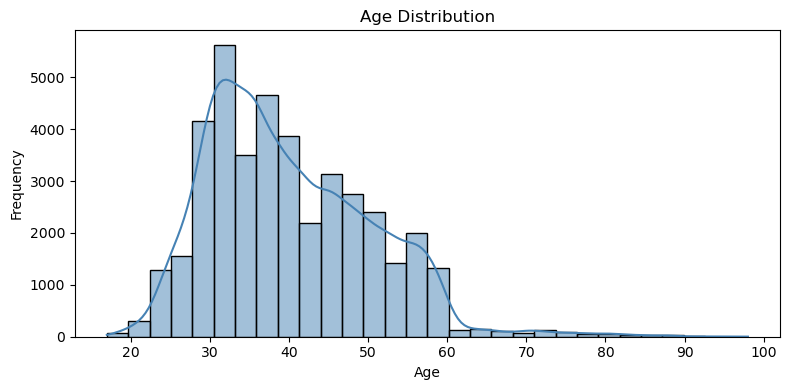

In [51]:
plt.figure(figsize=(8, 4))
sns.histplot(df_bank['age'], bins=30, kde=True, color='steelblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()


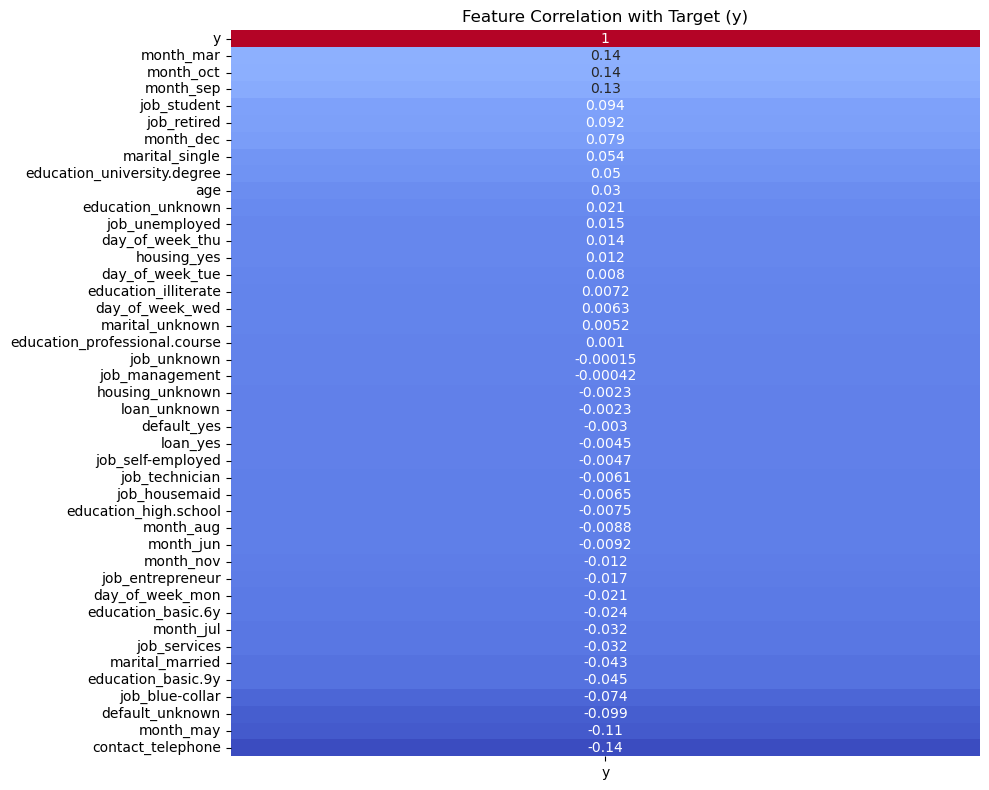

In [53]:
plt.figure(figsize=(10, 8))
corr = df_encoded.corr()
sns.heatmap(corr[['y']].sort_values(by='y', ascending=False), annot=True, cmap='coolwarm', cbar=False)
plt.title("Feature Correlation with Target (y)")
plt.tight_layout()


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The objective is to develop and compare multiple classification models to predict whether a client will subscribe to a term deposit, using historical marketing data from a Portuguese bank. This will enable the bank to optimize its telemarketing strategy, reduce campaign costs, and improve conversion rates by focusing on clients most likely to respond positively.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [60]:
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
target = 'y'

# Copy relevant columns
df_bank = df[bank_features + [target]].copy()

# Encode target column: 'yes' -> 1, 'no' -> 0
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_bank, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week'], drop_first=True)

# Preview result
df_encoded.head()

,age,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,57,0,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
2,37,0,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
3,40,0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,56,0,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [63]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes to verify
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (32950, 42), (32950,)
Test shape: (8238, 42), (8238,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [66]:
# Calculate baseline by predicting the majority class
baseline_class = y_train.value_counts().idxmax()
baseline_accuracy = (y_test == baseline_class).mean()

print(f"Baseline prediction (always predict '{baseline_class}')")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")


Baseline prediction (always predict '0')
Baseline accuracy: 0.8874


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.887836853605244

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      7310
           1       0.51      0.07      0.13       928

    accuracy                           0.89      8238
   macro avg       0.70      0.53      0.53      8238
weighted avg       0.85      0.89      0.85      8238


Confusion Matrix:
 [[7245   65]
 [ 859   69]]


### Problem 9: Score the Model

What is the accuracy of your model?

In [74]:
# Accuracy score of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.8878


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [77]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dictionary to hold model results
results = []

# List of models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC()
}

# Loop through each model
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_time = end - start
    
    results.append({
        "Model": name,
        "Train Time (s)": round(train_time, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4)
    })

# Display results as a DataFrame
results_df = pd.DataFrame(results)
results_df


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.2462,0.8872,0.8878
1,K-Nearest Neighbors,0.0060,0.9030,0.8795
2,Decision Tree,0.0995,0.9774,0.8328
3,SVM,7.4511,0.8873,0.8874


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [79]:
# Example: Drop 'contact' and 'month' as they might add noise
X_train_reduced = X_train.drop(['contact_unknown', 'month_may'], axis=1, errors='ignore')
X_test_reduced = X_test.drop(['contact_unknown', 'month_may'], axis=1, errors='ignore')


In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_knn.fit(X_train, y_train)

print("Best KNN params:", grid_knn.best_params_)
print("Best KNN test accuracy:", grid_knn.score(X_test, y_test))


Best KNN params: {'n_neighbors': 9}
Best KNN test accuracy: 0.8855304685603301


In [81]:
param_grid = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_dt.fit(X_train, y_train)

print("Best DT params:", grid_dt.best_params_)
print("Best DT test accuracy:", grid_dt.score(X_test, y_test))


Best DT params: {'max_depth': 5, 'min_samples_split': 5}
Best DT test accuracy: 0.8891721291575625


In [82]:
from sklearn.metrics import f1_score, roc_auc_score

y_pred_proba = grid_dt.predict_proba(X_test)[:, 1]
y_pred_labels = grid_dt.predict(X_test)

print("F1 Score:", f1_score(y_test, y_pred_labels))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


F1 Score: 0.18699910952804988
ROC-AUC Score: 0.6869481608802301


## Conclusion

In this project, we explored the effectiveness of various machine learning models in predicting whether a client would subscribe to a term deposit, using a dataset of Portuguese bank marketing campaigns.

We began by understanding and preprocessing the data, including encoding categorical features, handling unknown values, and splitting the data into training and testing sets. A baseline model was established by always predicting the majority class, achieving an accuracy of 88.74%.

We then trained and evaluated four models using default parameters: Logistic Regression, K-Nearest Neighbors, Decision Tree, and Support Vector Machine. Among them:
- **Logistic Regression** and **SVM** offered the best generalization with test accuracies of ~88.7%, slightly outperforming the baseline.
- **KNN** was computationally efficient but slightly underperformed on test accuracy.
- **Decision Tree** overfit the training data, showing the highest training accuracy but lowest test accuracy.

We visualized the dataset to better understand the distributions and relationships between key features, and we identified potential next steps such as hyperparameter tuning, feature selection, and alternative evaluation metrics (e.g., F1-score or ROC-AUC) to improve performance, particularly in handling the imbalanced target variable.

### Key Takeaways:
- Logistic Regression offers a solid, interpretable baseline with strong performance.
- Additional tuning and model calibration may help improve recall for minority classes.
- Feature distributions and correlation analysis can guide model refinement.
- Machine learning can provide measurable lift over naïve marketing approaches, helping reduce costs and increase conversions.

This work demonstrates the value of combining data understanding, model comparison, and practical evaluation to inform business decisions in marketing contexts.
